In [2]:
!pip install opencv-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 MB 1.7 MB/s eta 0:00:00m eta 0:00:010:00:01


In [215]:
import pandas as pd
import numpy as np
import glob
from tqdm import tqdm
import cv2
from sklearn.model_selection import train_test_split
import os

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torchvision import datasets, models, transforms
from torchvision.models import resnet18

from tqdm import tqdm
from tqdm.auto import tqdm as tqdm_
from tqdm.notebook import tqdm as tqdm_step

from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import clear_output

## Датасет

Прежде чем разбираться с моделями, нам надо в первую очередь разобраться с тем, как грузить датасет. Давайте напишем класс в торче для этого.

In [21]:
DIR_TRAIN = "./dataset/train/"
DIR_TEST = "./dataset/test/"

PATH_TRAIN = "./dataset/train.csv"
PATH_TEST = "./dataset/test.csv"

In [22]:
class ImageDataset(Dataset):
    def __init__(self, data_df, transform=None):

        self.data_df = data_df
        self.transform = transform

    def __getitem__(self, idx):
        # достаем имя изображения и ее лейбл
        image_name, label = self.data_df.iloc[idx]['ID_img'], self.data_df.iloc[idx]['class']

        # читаем картинку. read the image
        image = cv2.imread(DIR_TRAIN + f"{image_name}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image)
        
        # преобразуем, если нужно. transform it, if necessary
        if self.transform:
            image = self.transform(image)
        
        return image, torch.tensor(label).long()
    
    def __len__(self):
        return len(self.data_df)

In [23]:
# задаем преобразование изображения.

train_transform = transforms.Compose([
    #transforms.Resize(256),
    transforms.RandomResizedCrop(256),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225]),
])

valid_transform = transforms.Compose([
    #transforms.Resize(256),
    transforms.RandomResizedCrop(256),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225]),
])

Загруим датасет как архив и откроем его 

In [24]:
!unzip МФТИ.zip -d /content/МФТИ/

unzip:  cannot find or open МФТИ.zip, МФТИ.zip.zip or МФТИ.zip.ZIP.


In [25]:
# читаем датасет
data_df = pd.read_csv(PATH_TRAIN)

In [26]:
data_df.head(3)

,ID_img,class
0,2138.jpg,4.0
1,2139.jpg,6.0
2,2140.jpg,3.0


In [27]:
from os import listdir

print("Обучающей выборки " ,len(listdir(DIR_TRAIN)))
print("Тестовой выборки " ,len(listdir(DIR_TEST)))

Обучающей выборки  4990
Тестовой выборки  2138


<AxesSubplot:xlabel='class', ylabel='count'>

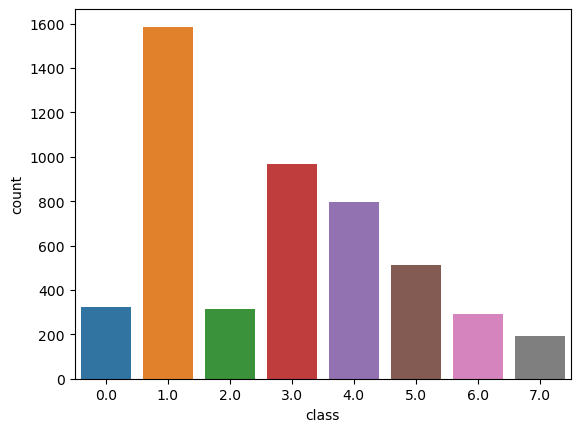

In [28]:
import seaborn as sns
import warnings

warnings.simplefilter('ignore')
sns.countplot(x = "class" , data  = data_df)

In [29]:
data_df

,ID_img,class
0,2138.jpg,4.0
1,2139.jpg,6.0
2,2140.jpg,3.0
3,2141.jpg,6.0
4,2142.jpg,3.0
...,...,...
4985,7123.jpg,2.0
4986,7124.jpg,3.0
4987,7125.jpg,2.0
4988,7126.jpg,4.0


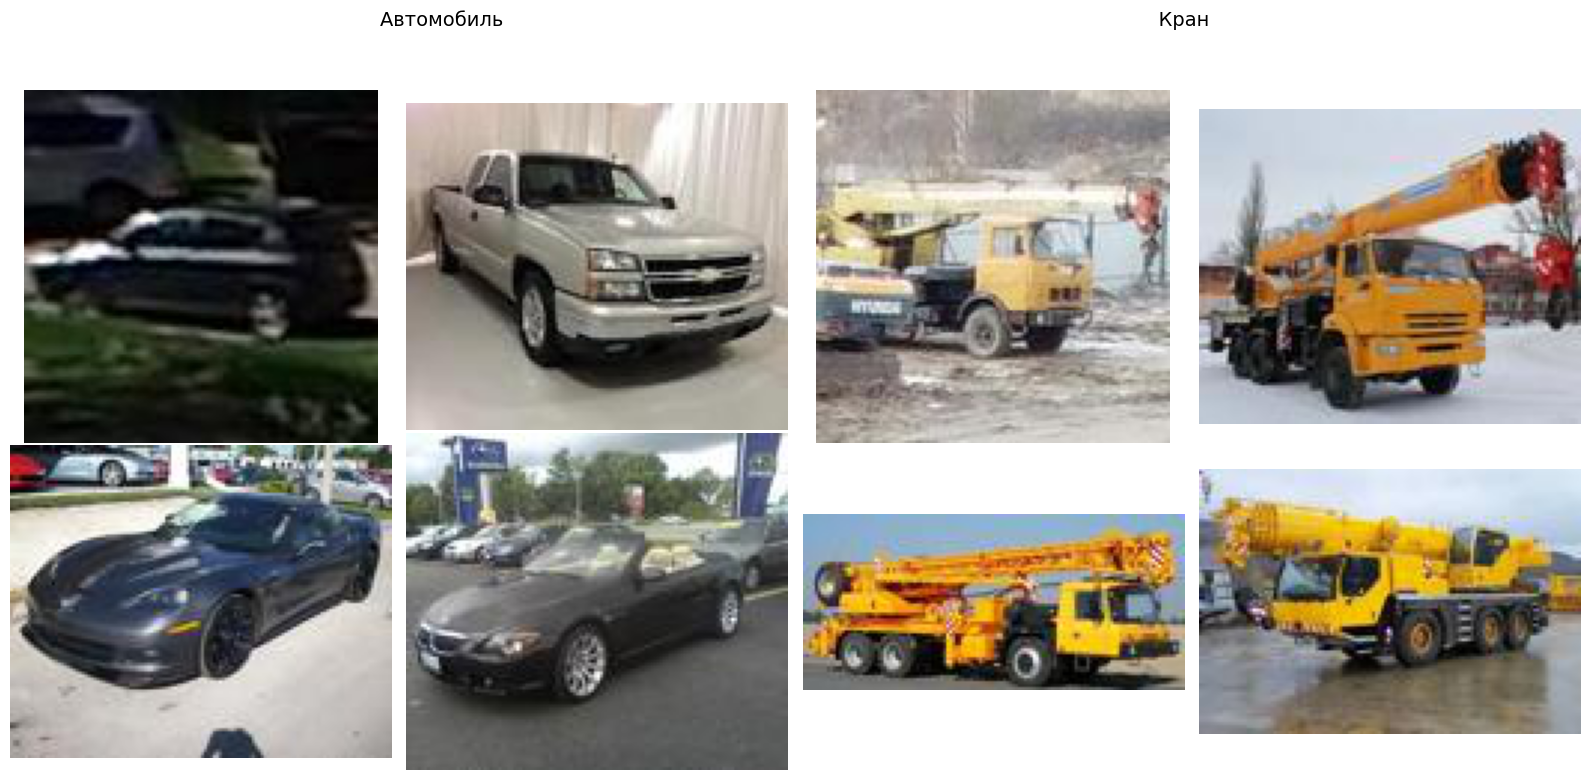

In [30]:
# посмотрим на картинки. Не забудем указать корретный путь до папки

fig, axs = plt.subplots(2, 4, figsize=(16,8))
fig.suptitle(f'Автомобиль {" "*105} Кран', fontsize=14)

for i, name in zip(range(4), data_df[ data_df['class'] == 1 ].sample(4, random_state=42)['ID_img']):
    axs[i // 2, (i % 2)].imshow(plt.imread(DIR_TRAIN + f"{name}"))
    axs[i // 2, (i % 2)].axis('off')

for i, name in zip(range(4), data_df[ data_df['class'] == 0 ].sample(4, random_state=42)['ID_img']):
    axs[i // 2, (i % 2)+2].imshow(plt.imread(DIR_TRAIN + f"{name}"))
    axs[i // 2, (i % 2)+2].axis('off')

fig.tight_layout()
fig.subplots_adjust(top=0.88)

In [31]:
# разделим датасет на трейн и валидацию, чтобы смотреть на качество
train_df, valid_df = train_test_split(data_df, test_size=0.2, random_state=43)

In [32]:
train_df.shape, valid_df.shape

((3992, 2), (998, 2))

In [33]:
train_dataset = ImageDataset(train_df, train_transform)
valid_dataset = ImageDataset(valid_df, valid_transform)

In [34]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=32,
                                           shuffle=True,
                                           pin_memory=True,
                                           num_workers=2)

valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset,
                                           batch_size=32,
                                           # shuffle=True,
                                           pin_memory=True,
                                           num_workers=2)

## Вспомогательные функции

In [35]:
def crossvalid(res_model=None,criterion=None,optimizer=None,dataset=None,k_fold=5):
    
    train_score = pd.Series()
    val_score = pd.Series()
    
    total_size = len(dataset)
    fraction = 1/k_fold
    seg = int(total_size * fraction)
    # tr:train,val:valid; r:right,l:left;  eg: trrr: right index of right side train subset 
    # index: [trll,trlr],[vall,valr],[trrl,trrr]
    for i in range(k_fold):
        trll = 0
        trlr = i * seg
        vall = trlr
        valr = i * seg + seg
        trrl = valr
        trrr = total_size
        
        train_left_indices = list(range(trll,trlr))
        train_right_indices = list(range(trrl,trrr))
        
        train_indices = train_left_indices + train_right_indices
        val_indices = list(range(vall,valr))
        
        train_set = torch.utils.data.dataset.Subset(dataset,train_indices)
        val_set = torch.utils.data.dataset.Subset(dataset,val_indices)
        
        train_loader = torch.utils.data.DataLoader(train_set, batch_size=50,
                                          shuffle=True, num_workers=4)
        val_loader = torch.utils.data.DataLoader(val_set, batch_size=50,
                                          shuffle=True, num_workers=4)
        train_acc = train(res_model,criterion,optimizer,train_loader,val_loader,1)
        train_score.at[i] = train_acc
        val_acc = valid(res_model,criterion,optimizer,val_loader)
        val_score.at[i] = val_acc
    
    return train_score,val_score

In [36]:
def plot_history(train_history, val_history, title='loss'):
    plt.figure()
    plt.title('{}'.format(title))
    dd = list(map(lambda x: x.cpu().detach().numpy(), train_history))
    plt.plot(dd, label='train', zorder=1)
    
    points = np.array(val_history)
    steps = list(range(0, len(train_history) + 1, int(len(train_history) / len(val_history))))[1:]

    plt.scatter(steps, val_history, marker='+', s=180, c='orange', label='val', zorder=2)
    plt.xlabel('train steps')
    
    plt.legend(loc='best')
    plt.grid()

    plt.show()

In [355]:
import os
import json

In [376]:
def train(res_model, criterion, optimizer, train_dataloader, test_dataloader, device, NUM_EPOCH=15):
    train_loss_log = []
    val_loss_log = []
    
    train_acc_log = []
    val_acc_log = []
    pbar_epoch = tqdm_step(range(NUM_EPOCH), desc="Epoch")
    
    for epoch in pbar_epoch:
        model.train()
        train_loss = 0.
        train_size = 0
        
        train_pred = 0.
        pbar_train = tqdm_step(train_dataloader, desc="Training")

        for imgs, labels in pbar_train:
            optimizer.zero_grad()

            imgs = imgs.to(device)
            labels = labels.to(device)

            y_pred = model(imgs)
            
            loss = criterion(y_pred, labels)
            loss.backward()
            
            l = loss.item()
            train_loss += l
            train_size += y_pred.size(0)
            train_loss_log.append(loss.data / y_pred.size(0))
            
            pred_acc = (y_pred.argmax(-1) == labels.argmax(-1)).sum()
            
            train_pred += pred_acc

            optimizer.step()
            pbar_train.postfix = f"loss = {l},  acc = {pred_acc/y_pred.size(0)}"

        train_acc_log.append(train_pred / train_size)

        val_loss = 0.
        val_size = 0
        
        val_pred = 0.
        
        model.eval()
        
        with torch.no_grad():
            pbar_testing = tqdm_step(test_dataloader, desc="Testing")
            for imgs, labels in pbar_testing:
                
                imgs = imgs.to(device)
                labels = labels.to(device)
                
                pred = model(imgs)
                loss = criterion(pred, labels)
                l = loss.item()
                val_loss += l
                val_size += pred.size(0)
                pred_acc = (pred.argmax(-1) == labels.argmax(-1)).sum()
                val_pred += pred_acc
                pbar_testing.postfix = f"loss = {l},  acc = {pred_acc / pred.size(0)}"
        

        val_loss_log.append(val_loss / val_size)
        val_acc_log.append(val_pred / val_size)

        clear_output()
        plot_history(train_loss_log, val_loss_log, 'loss')
        print(f'Epoch {NUM_EPOCH}/{epoch+1}')
        print('-----')
        print('Train loss:' + str((train_loss / train_size)*100))
        print('Val loss:' + str((val_loss / val_size)*100))
        print('Train acc:' + str((train_pred / train_size)*100))
        val_acc = (val_pred / val_size)*100
        print('Val acc:'+ str(val_acc))
        
        
        if not os.path.exists("./last.state"):
            with open("./last.state", "w") as f:
                f.write(json.dumps({"val_acc":val_acc.item()}))
        else:
            with open("./last.state", "r") as f:
                val = f.read()
                state = json.loads(val)
            if val_acc > state["val_acc"]:
                with open("./last.state", "w") as f:
                    f.write(json.dumps({"val_acc":val_acc.item()}))
                if os.path.exists("./best_model.mdl"):
                    os.rename('./best_model.mdl', f'./model_{str(state["val_acc"])}.mdl')
                torch.save(model.state_dict(), './best_model.mdl')
                print('Сохранено!')
        
    return train_loss_log, train_acc_log, val_loss_log, val_acc_log

## Модель

Если надо почистить память

In [208]:
import gc

gc.collect()

20

In [209]:
torch.cuda.empty_cache()

In [205]:
import torch.nn.functional as F
import random
from PIL import Image as PImage

In [255]:
params = {
    "path":["./DBeaver_dataset.json", "./MonitorOff_dataset.json", "./PyCharm_dataset.json", "./SSMS_dataset.json", "./VisualStudio_dataset.json", "./Windows_enter_dataset.json"],
    "path_img":"./Dataset/",
    "lr": 0.0001,
    "batch_size": 32,
    "num_workers": 4,
    "epochs": 4,
    "size": 128,
    "device": torch.device("cuda:1" if torch.cuda.is_available() else "cpu"),
    "path_model_boxs":"./models/box_vga_dict_2_2.mdl",
    "path_model_recognasion":"./models/recognation2_vga.mdl",
}

In [ ]:
train_transform = transforms.Compose([
    #transforms.Resize(256),
    transforms.RandomResizedCrop(256),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225]),
])

valid_transform = transforms.Compose([
    #transforms.Resize(256),
    transforms.RandomResizedCrop(256),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225]),
])

In [379]:
train_transform = transforms.Compose([
    #trf.ToPILImage(),
    #trf.Resize((512, 512)),
    transforms.Resize((int(params['size'] * 1.3), int(params['size'] * 1.3))),
    #trf.Resize((int(params['size']), int(params['size']))),
    transforms.RandomCrop((params['size'], params['size'])),
    transforms.RandomRotation(10.0),
    transforms.RandomAffine(degrees=(-5,5), translate=(0, 0.3), scale=(0.75, 1.0)),
    #trf.RandomApply(transforms=[trf.ElasticTransform(alpha=50.0)], p=0.5),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.05, hue=0.05), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225]),
])
valid_transform = transforms.Compose([
    transforms.Resize((params['size'], params['size'])),
    #transforms.RandomResizedCrop(params['size']),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225]),
])

In [380]:
all_class = set()
for e in np.unique(train_df['class'].to_numpy()):
    all_class.add(int(e))
for e in np.unique(valid_df['class'].to_numpy()):
    all_class.add(int(e))
all_class

{0, 1, 2, 3, 4, 5, 6, 7}

In [381]:
class ImageDataset(Dataset):
    def __init__(self, data_df, transform=None):

        self.data_df = data_df
        self.transform = transform

    def __getitem__(self, idx):
        # достаем имя изображения и ее лейбл
        image_name, label = self.data_df.iloc[idx]['ID_img'], self.data_df.iloc[idx]['class']

        # читаем картинку. read the image
        image = cv2.imread(DIR_TRAIN + f"{image_name}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image)
        
        # преобразуем, если нужно. transform it, if necessary
        if self.transform:
            image = self.transform(image)
        
        return image, torch.tensor(np.array([1.0 if idx == label else 0.0 for idx, e in enumerate(range(len(all_class)))]))
    
    def __len__(self):
        return len(self.data_df)

In [382]:
train_dataset = ImageDataset(train_df, train_transform)
valid_dataset = ImageDataset(valid_df, valid_transform)

In [383]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=params['batch_size'],
                                           shuffle=True,
                                           pin_memory=True,
                                           num_workers=params['num_workers'])

valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset,
                                           batch_size=params['batch_size'],
                                           # shuffle=True,
                                           pin_memory=True,
                                           num_workers=params['num_workers'])

In [284]:
class CNN(nn.Module):
    def __init__(self, **kwargs):
        super(CNN, self).__init__()
        self.convlayer1 = nn.Sequential(
            nn.Conv2d(in_channels=kwargs["input_shape"], out_channels=64, kernel_size=(4, 4)),
        )
        
        self.maxpooling1 = nn.Sequential(
            nn.MaxPool2d(2, stride=2),
            nn.BatchNorm2d(64),
        )
        
        self.convlayer2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(4, 4)),
        )
        
        self.maxpooling2 = nn.Sequential(
            nn.MaxPool2d(2, stride=2),
            nn.Dropout(0.2),
            nn.BatchNorm2d(64),
        )
        
        self.convlayer3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(4, 4)),
        )
        
        self.maxpooling3 = nn.Sequential(
            nn.MaxPool2d(2, stride=2),
            nn.Dropout(0.25),
            nn.BatchNorm2d(64),
        )
        
        self.flatten = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=53824, out_features=len(all_class), bias=True),
        )

    def forward(self, x):
        x = nn.functional.relu(self.convlayer1(x))
        x = self.maxpooling1(x)
        x = nn.functional.relu(self.convlayer2(x))
        x = self.maxpooling2(x)
        x = nn.functional.relu(self.convlayer3(x))
        x = self.maxpooling3(x)
        x = nn.functional.softmax(self.flatten(x), -1)
        
        return x

In [305]:
class SeparableConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, bias=False, strides=1, padding=0, activation='relu'):
        super(SeparableConv2d, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=kernel_size,
                                   groups=in_channels, bias=bias, padding=padding, stride=strides)
        self.pointwise = nn.Conv2d(in_channels, out_channels,
                                   kernel_size=1, bias=bias, stride=strides)
        self.activation = activation
    def forward(self, x):
        if self.activation == 'relu':
            out = torch.relu(self.depthwise(x))
            out = torch.relu(self.pointwise(out))
        elif self.activation == 'sigmoid':
            out = torch.sigmoid(self.depthwise(x))
            out = torch.sigmoid(self.pointwise(out))
        else:
            out = self.depthwise(x)
            out = self.pointwise(out)
    
        return out

In [ ]:
class SeparableConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, bias=False, strides=1, padding=0, activation='relu'):
        super(SeparableConv2d, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=kernel_size,
                                   groups=in_channels, bias=bias, padding=padding, stride=strides)
        self.pointwise = nn.Conv2d(in_channels, out_channels,
                                   kernel_size=1, bias=bias, stride=strides)
        self.activation = activation
    def forward(self, x):
        out1 = torch.relu(self.depthwise(x))
        out1 = torch.relu(self.pointwise(out1))
        
        out2 = torch.sigmoid(self.depthwise(x))
        out2 = torch.sigmoid(self.pointwise(out2))
        
        out = concatcat((out1, out2), dim=-1)

        return out

In [344]:
class CNN(nn.Module):
    def __init__(self, **kwargs):
        super(CNN, self).__init__()
        self.convlayer0_1 = nn.Sequential(
            nn.Conv2d(in_channels=kwargs["input_shape"], out_channels=16, kernel_size=(4, 4), padding=2),
            nn.Conv2d(in_channels=16, out_channels=24, kernel_size=(4, 4),padding=2),
            nn.MaxPool2d(2, stride=2),
            nn.Dropout(0.2),
            nn.BatchNorm2d(24),
        )
        
        self.convlayer0_2 = nn.Sequential(
            nn.Conv2d(in_channels=24, out_channels=32, kernel_size=(5, 5),padding=2),
            nn.Conv2d(in_channels=32, out_channels=48, kernel_size=(5, 5),padding=2),
            nn.MaxPool2d(2, stride=2),
            nn.Dropout(0.2),
            nn.BatchNorm2d(48),
        )
        
        self.convlayer0_3 = nn.Sequential(
            nn.Conv2d(in_channels=48, out_channels=64, kernel_size=(5, 5),padding=1),
            nn.Conv2d(in_channels=64, out_channels=92, kernel_size=(5, 5),padding=1),
            nn.MaxPool2d(2, stride=2),
            nn.Dropout(0.2),
            nn.BatchNorm2d(92),
        )
        
        self.convlayer1 = nn.Sequential(
            SeparableConv2d(in_channels=92, out_channels=128, kernel_size=(5, 5), strides=1,padding=1),
            nn.BatchNorm2d(128), #nn.ReLU(),
            SeparableConv2d(in_channels=128, out_channels=128, kernel_size=(5, 5), strides=1,padding=1),
            nn.Dropout(0.2),
            nn.BatchNorm2d(128), #nn.ReLU(),
        )
        self.convlayer2 = nn.Sequential(
            SeparableConv2d(in_channels=128, out_channels=128, kernel_size=(5, 5), strides=1,padding=1), #nn.ReLU(),
            SeparableConv2d(in_channels=128, out_channels=128, kernel_size=(5, 5), strides=1,padding=1), #nn.ReLU(),
        )
        self.convlayer3 = nn.Sequential(
            SeparableConv2d(in_channels=128, out_channels=128, kernel_size=(5, 5), strides=1,padding=1),
            nn.BatchNorm2d(128), #nn.ReLU(),
            SeparableConv2d(in_channels=128, out_channels=128, kernel_size=(5, 5), strides=1,padding=1),
            nn.Dropout(0.2),
            nn.BatchNorm2d(128), #nn.ReLU(),
        )
        
        self.flatten = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=512, out_features=256),
            nn.Linear(in_features=256, out_features=128),
            nn.Dropout(0.2),
            nn.BatchNorm1d(128), #nn.ReLU(),
        )
        self.pred = nn.Sequential(
            nn.Linear(in_features=128, out_features=len(all_class), bias=True),
        )

    def forward(self, x):
        x = nn.functional.relu(self.convlayer0_1(x))
        x = nn.functional.relu(self.convlayer0_2(x))
        x = nn.functional.relu(self.convlayer0_3(x))
        x = nn.functional.relu(self.convlayer1(x))
        x = nn.functional.relu(self.convlayer2(x))
        x = nn.functional.relu(self.convlayer3(x))
        x = nn.functional.relu(self.flatten(x))
        x = nn.functional.log_softmax(self.pred(x), -1)
        
        return x

In [384]:
device = torch.device(params['device'])
model = CNN(input_shape=3).to(device)
criterion = nn.MSELoss()

In [385]:
criterion = nn.CrossEntropyLoss()

In [386]:
def calculate_accuracy_(target, output):
    return float(torch.sum(torch.eq(torch.argmax(target, dim=1),torch.argmax(output, dim=1))).numpy())/ len(target)

In [392]:
optimizer = optim.Adam(model.parameters(), lr=params['lr']*0.5)#1e-3)

In [349]:
try:
    print(model.load_state_dict(params['path_model']))
except:
    print("Модель не загрузилась")

Модель не загрузилась


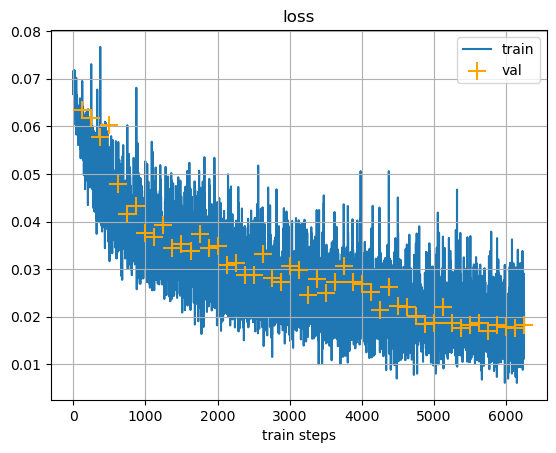

Epoch 50/50
-----
Train loss:1.8234975805265266
Val loss:1.8285009046298262
Train acc:tensor(80.9870, device='cuda:1')
Val acc:tensor(81.1623, device='cuda:1')


In [350]:
history = train(model, criterion, optimizer, train_loader, valid_loader, device, 50)

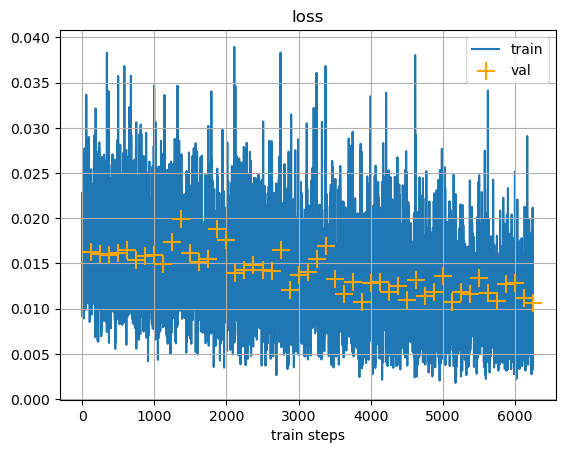

Epoch 50/50
-----
Train loss:1.0506605775383697
Val loss:1.0632003052209789
Train acc:tensor(89.2034, device='cuda:1')
Val acc:tensor(90.2806, device='cuda:1')


In [351]:
history = train(model, criterion, optimizer, train_loader, valid_loader, device, 50)

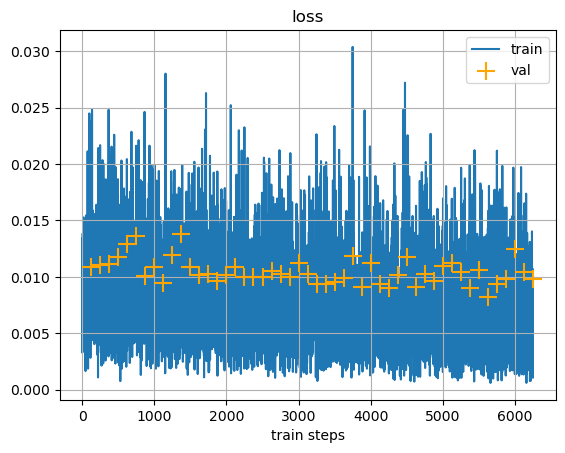

Epoch 50/50
-----
Train loss:0.6612687082690665
Val loss:0.9767067955295146
Train acc:tensor(92.9609, device='cuda:1')
Val acc:tensor(90.5812, device='cuda:1')


In [377]:
history = train(model, criterion, optimizer, train_loader, valid_loader, device, 50)

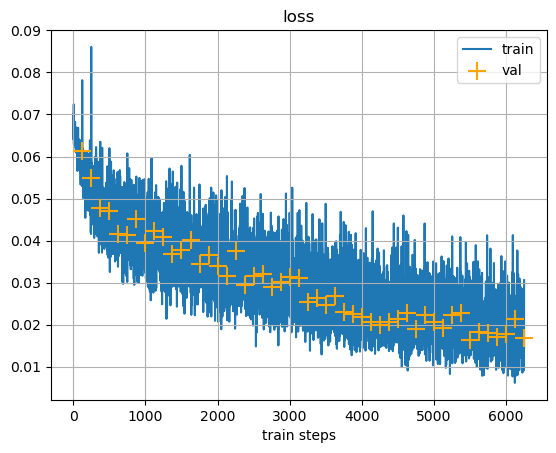

Epoch 50/50
-----
Train loss:1.876315304286644
Val loss:1.6852903861565331
Train acc:tensor(80.8116, device='cuda:1')
Val acc:tensor(82.6653, device='cuda:1')
CPU times: user 9min 37s, sys: 44.2 s, total: 10min 21s
Wall time: 9min 54s


In [388]:
%%time
history = train(model, criterion, optimizer, train_loader, valid_loader, device, 50)

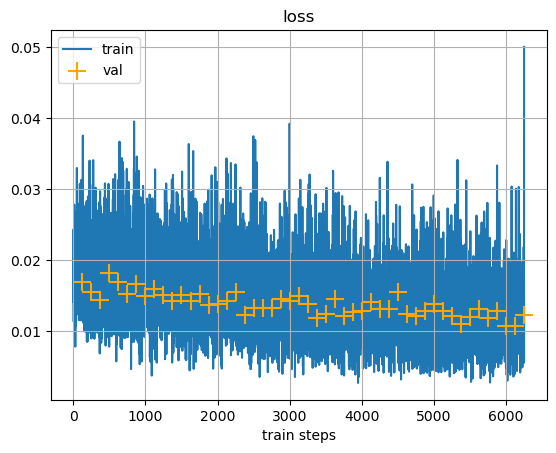

Epoch 50/50
-----
Train loss:1.174703199593006
Val loss:1.2197175579267927
Train acc:tensor(87.7004, device='cuda:1')
Val acc:tensor(88.0762, device='cuda:1')
CPU times: user 9min 43s, sys: 44.7 s, total: 10min 28s
Wall time: 10min


In [389]:
%%time
history = train(model, criterion, optimizer, train_loader, valid_loader, device, 50)

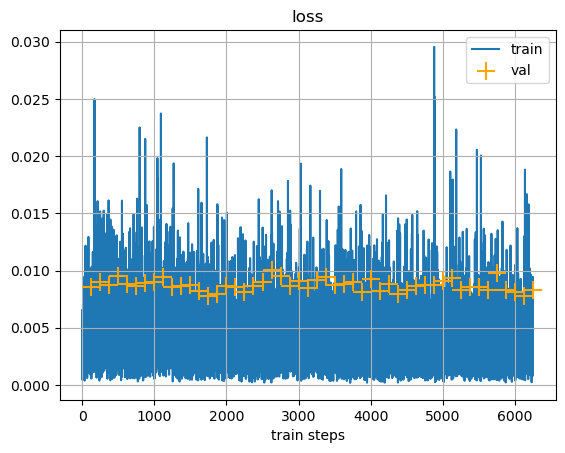

Epoch 50/50
-----
Train loss:0.44222253427003005
Val loss:0.8342924559708065
Train acc:tensor(95.7164, device='cuda:1')
Val acc:tensor(92.6854, device='cuda:1')
CPU times: user 9min 40s, sys: 44.4 s, total: 10min 25s
Wall time: 9min 57s


In [394]:
%%time
history = train(model, criterion, optimizer, train_loader, valid_loader, device, 50)

In [409]:
class ImageDatasetSampler(Dataset):
    def __init__(self, data_df, mask, transform=None):
        self.mask = mask
        self.data_df = data_df
        self.transform = transform

    def __getitem__(self, idx):
        # достаем имя изображения и ее лейбл
        image_name, label = self.data_df.iloc[self.mask[idx]]['ID_img'], self.data_df.iloc[self.mask[idx]]['class']

        # читаем картинку. read the image
        image = cv2.imread(DIR_TRAIN + f"{image_name}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image)
        
        # преобразуем, если нужно. transform it, if necessary
        if self.transform:
            image = self.transform(image)
        
        return image, torch.tensor(np.array([1.0 if idx == label else 0.0 for idx, e in enumerate(range(len(all_class)))]))
    
    def __len__(self):
        return len(self.mask)

In [412]:
def crossvalid(res_model=None,criterion=None,optimizer=None,dataset=None,k_fold=5):
    
    train_score = pd.Series()
    val_score = pd.Series()
    
    total_size = len(dataset)
    fraction = 1/k_fold
    seg = int(total_size * fraction)
    # tr:train,val:valid; r:right,l:left;  eg: trrr: right index of right side train subset 
    # index: [trll,trlr],[vall,valr],[trrl,trrr]
    for i in range(k_fold):
        trll = 0
        trlr = i * seg
        vall = trlr
        valr = i * seg + seg
        trrl = valr
        trrr = total_size
        
        train_left_indices = list(range(trll,trlr))
        train_right_indices = list(range(trrl,trrr))
        
        train_indices = train_left_indices + train_right_indices
        val_indices = list(range(vall,valr))

        train_dataset = ImageDatasetSampler(dataset,train_indices, train_transform)
        valid_dataset = ImageDatasetSampler(dataset,val_indices, valid_transform)
        #train_set = torch.utils.data.dataset.Subset(dataset,train_indices)
        #val_set = torch.utils.data.dataset.Subset(dataset,val_indices)
        
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=params['batch_size'], 
                                          shuffle=True, num_workers=params['num_workers'])
        val_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=params['batch_size'], 
                                          shuffle=True, num_workers=params['num_workers'])
        
        train_acc = train(res_model,criterion,optimizer,train_loader,val_loader,1)
        train_score.at[i] = train_acc
        val_acc = valid(res_model,criterion,optimizer,val_loader)
        val_score.at[i] = val_acc
    
    return train_score,val_score

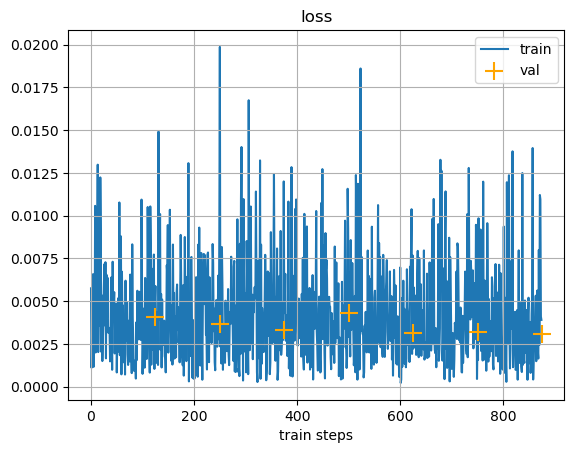

Epoch 15/7
-----
Train loss:0.40284783435470567
Val loss:0.30844421542787365
Train acc:tensor(96.0671, device='cuda:1')
Val acc:tensor(97.0942, device='cuda:1')


Training:   0%|          | 0/125 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f68637098b0>
Traceback (most recent call last):
  File "/home/arhitegio/anaconda3/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/arhitegio/anaconda3/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/home/arhitegio/anaconda3/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
Exception ignored in: AssertionError: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f68637098b0>can only test a child process

Traceback (most recent call last):
  File "/home/arhitegio/anaconda3/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
Exception ignored in: Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x7f68637098b0>sel

RuntimeError: DataLoader worker (pid(s) 63154) exited unexpectedly

In [416]:
 crossvalid(model,criterion,optimizer,data_df,k_fold=5)

In [419]:
with open("./last.state", "w") as f:
    f.write(json.dumps({"val_acc":98.0}))

In [420]:
val_acc = 96.0671
with open("./last.state", "r") as f:
    val = f.read()
    state = json.loads(val)
with open("./last.state", "w") as f:
    f.write(json.dumps({"val_acc":val_acc}))
if os.path.exists("./best_model.mdl"):
    os.rename('./best_model.mdl', f'./model_{str(state["val_acc"])}.mdl')
torch.save(model.state_dict(), './best_model.mdl')
print('Сохранено!')

Exception ignored in: <function _ConnectionBase.__del__ at 0x7f68b7c171f0>
Traceback (most recent call last):
  File "/home/arhitegio/anaconda3/lib/python3.9/multiprocessing/connection.py", line 137, in __del__
    self._close()
  File "/home/arhitegio/anaconda3/lib/python3.9/multiprocessing/connection.py", line 366, in _close
Traceback (most recent call last):
  File "/home/arhitegio/anaconda3/lib/python3.9/multiprocessing/queues.py", line 239, in _feed
    reader_close()
  File "/home/arhitegio/anaconda3/lib/python3.9/multiprocessing/connection.py", line 182, in close
    self._close()
  File "/home/arhitegio/anaconda3/lib/python3.9/multiprocessing/connection.py", line 366, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor


Сохранено!


In [ ]:
train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(model, 
                                                                 criterion, 
                                                                optimizer, 
                                                                 train_loader, 
                                                                 valid_loader, 
                                                                 15)

In [421]:
model.eval()
valid_predicts = []

for imgs, _ in tqdm(valid_loader):
    
    imgs = imgs.to(device)
    pred = model(imgs)

    pred_numpy = pred.cpu().detach().numpy()

    for class_obj in pred_numpy:
      index, max_value = max(enumerate(class_obj), key=lambda i_v: i_v[1])
      valid_predicts.append(index)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 31.39it/s]


In [422]:
valid_df["pred"] = valid_predicts

# Посчитаем recall

In [423]:
from sklearn.metrics import recall_score

In [424]:
val_accuracy = recall_score(valid_df['class'].values, valid_df['pred'].values, average = "macro")
print(f"Validation accuracy = {val_accuracy}")

Validation accuracy = 0.9627225631449656


## Предскажем для теста

In [435]:
test_df_ = pd.read_csv(PATH_TEST)

array([0])

In [425]:
test_df = pd.read_csv(PATH_TEST)
test_df = test_df.drop(["class"], axis = 1)

In [426]:
class TestImageDataset(Dataset):
    def __init__(self, data_df, transform=None):
        self.data_df = data_df
        self.transform = transform

    def __getitem__(self, idx):
        image_name = self.data_df.iloc[idx]['ID_img']
        
        # читаем картинку
        image = cv2.imread(DIR_TEST+ f"{image_name}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image)
        
        # преобразуем, если нужно
        if self.transform:
            image = self.transform(image)
        
        return image
    
    def __len__(self):
        return len(self.data_df)

In [427]:
test_dataset = TestImageDataset(test_df, valid_transform)

In [428]:
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=32,
                                           # shuffle=True,
                                           pin_memory=True,
                                           num_workers=2)

#Предсказываем нашей моделью результат

In [430]:
model.eval()
predicts = []

for imgs in tqdm(test_loader):
    imgs = imgs.to(device)
    pred = model(imgs)
    for class_obj in pred:
      index, max_value = max(enumerate(class_obj), key=lambda i_v: i_v[1])
      predicts.append(index)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 29.57it/s]


In [431]:
test_df["class"] = predicts

test_df.head()

,ID_img,class
0,0.jpg,5
1,1.jpg,5
2,2.jpg,1
3,3.jpg,1
4,4.jpg,6


In [432]:
test_df.to_csv("submit.csv", index=False)